# Objective 4: Customer Segmentation

# 6. Customer Segmentation for Targeted Marketing

This notebook addresses Objective 4 of the dissertation: **To segment customers based on their purchasing behavior**. Using clustering techniques, particularly K-Means, we aim to identify distinct customer groups and explore how these insights can help personalize marketing efforts and increase engagement.

---

###  Business & Analytical Questions:

- **6.1**: How do we engineer features to represent customer purchasing behavior?  
  _Extract features such as order size, frequency, and product diversity to describe user behavior._

- **6.2**: How do we preprocess and normalize customer data for clustering?  
  _Ensure data is appropriately scaled for effective algorithmic processing._

- **6.3**: How can we use K-Means clustering to segment customers?  
  _Apply clustering to group customers based on behavioral patterns._

- **6.4**: How do we visualize and interpret customer segments?  
  _Use dimensionality reduction (e.g., PCA) and plots to explain cluster composition._

- **6.5**: What insights can be derived for targeted marketing?  
  _Identify actionable strategies to personalize promotions and communications._

---


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load prior dataset only
base_path = r"E:\Semester 2\Research Proposal\Msc Dissertation\Insta Cart data Set"

orders = pd.read_csv(f"{base_path}/orders.csv")
orders = orders[orders['eval_set'] == 'prior']

order_products = pd.read_csv(f"{base_path}/order_products__prior.csv")
products = pd.read_csv(f"{base_path}/products.csv")

In [3]:

# Merge orders with order_products
merged = order_products.merge(orders[['order_id', 'user_id', 'days_since_prior_order']], on='order_id')

# Calculate average order size per user
order_sizes = merged.groupby(['order_id', 'user_id']).size().reset_index(name='order_size')
avg_order_size = order_sizes.groupby('user_id')['order_size'].mean()

# Average days between orders
avg_days = merged.groupby('user_id')['days_since_prior_order'].mean()

# Number of unique products bought
unique_products = merged.groupby('user_id')['product_id'].nunique()

# Combine into one DataFrame
df_customers = pd.DataFrame({
    'avg_order_size': avg_order_size,
    'avg_days_between_orders': avg_days,
    'distinct_products_bought': unique_products
}).reset_index()



### 6.1 How do we engineer features to represent customer purchasing behavior?

In [4]:
# Normalize features
features = ['avg_order_size', 'avg_days_between_orders', 'distinct_products_bought']
scaler = StandardScaler()
scaled = scaler.fit_transform(df_customers[features])

### 6.2 How do we preprocess and normalize customer data for clustering?

In [5]:

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_customers['cluster'] = kmeans.fit_predict(scaled)

### 6.3 How can we use K-Means clustering to segment customers?

In [6]:
# Reduce to 2D for plotting
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)
df_customers['PCA1'] = pca_result[:, 0]
df_customers['PCA2'] = pca_result[:, 1]

### 6.4 How do we visualize and interpret customer segments?

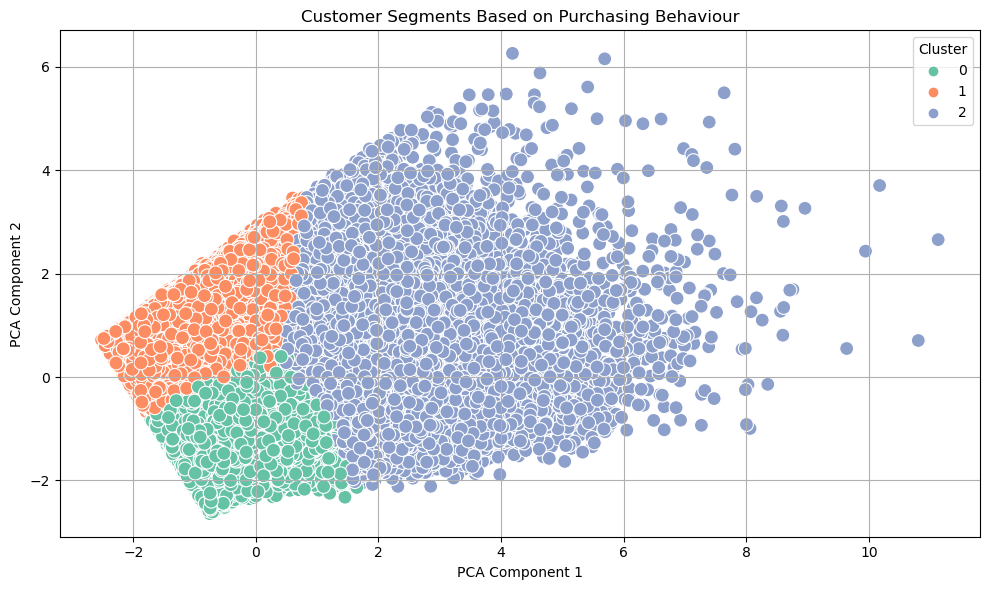

In [7]:
# Plot customer clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_customers, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=100)
plt.title("Customer Segments Based on Purchasing Behaviour")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.5 What insights can be derived for targeted marketing?

In [8]:
# Summarize cluster profiles
df_customers.groupby('cluster')[features].mean().round(2)

,avg_order_size,avg_days_between_orders,distinct_products_bought
cluster,,,
0,7.38,10.76,48.33
1,8.52,23.24,34.27
2,16.72,12.03,139.59


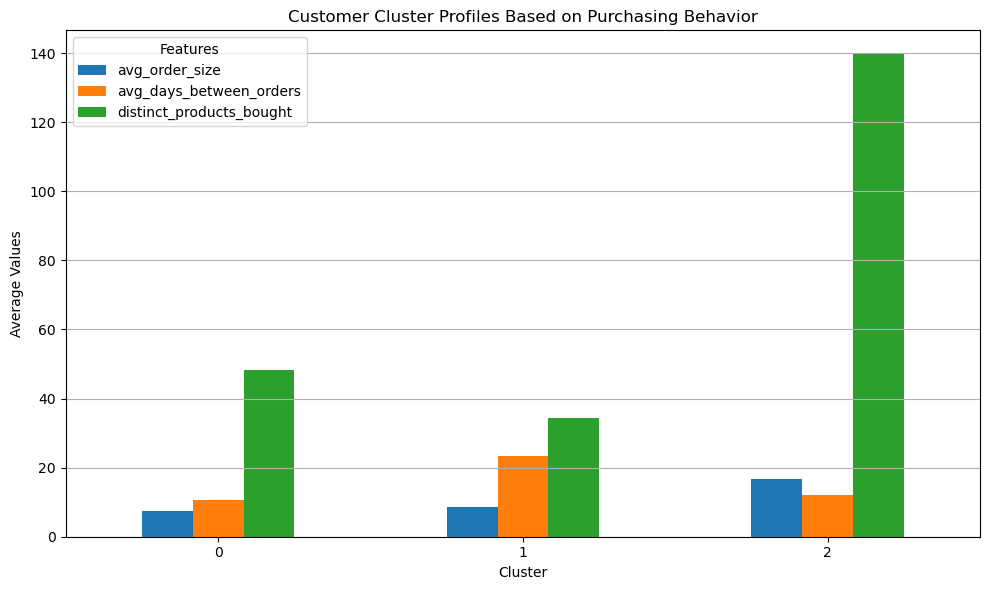

In [9]:

# Re-create the cluster profile data
cluster_profile_data = {
    'cluster': [0, 1, 2],
    'avg_order_size': [7.38, 8.52, 16.72],
    'avg_days_between_orders': [10.76, 23.24, 12.03],
    'distinct_products_bought': [48.33, 34.27, 139.59]
}
df_cluster_profiles = pd.DataFrame(cluster_profile_data).set_index('cluster')

# Create a grouped bar chart for cluster profiling
df_cluster_profiles.plot(kind='bar', figsize=(10, 6))
plt.title('Customer Cluster Profiles Based on Purchasing Behavior')
plt.xlabel('Cluster')
plt.ylabel('Average Values')
plt.xticks(rotation=0)
plt.legend(title='Features')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

##  RFM Analysis (Recency, Frequency, Monetary Value)
We will compute RFM features for each customer to better understand their purchase behavior.

In [10]:
# RFM Analysis
# Calculate RFM metrics
# Recency: Days since last order

latest_orders = orders.groupby('user_id')['order_number'].max().reset_index()
recency = orders.groupby('user_id')['days_since_prior_order'].last().reset_index().fillna(0)
frequency = orders.groupby('user_id')['order_id'].nunique().reset_index()
monetary = order_products.groupby('order_id').size().reset_index(name='products_count')
monetary = orders.merge(monetary, on='order_id').groupby('user_id')['products_count'].sum().reset_index()

rfm = recency.merge(frequency, on='user_id')
rfm = rfm.merge(monetary, on='user_id')
rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']
rfm.head(1000)

,user_id,Recency,Frequency,Monetary
0,1,30.0,10,59
1,2,13.0,14,195
2,3,15.0,12,88
3,4,0.0,5,18
4,5,19.0,4,37
...,...,...,...,...
995,996,25.0,4,45
996,997,30.0,17,114
997,998,15.0,26,345
998,999,3.0,38,1001


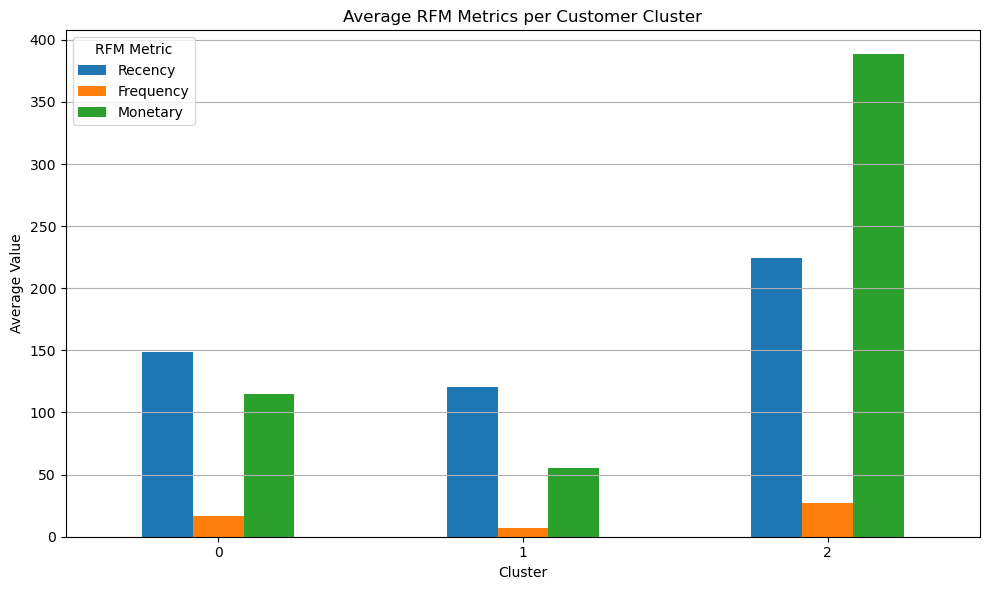

In [11]:
# Re-import necessary packages after code execution environment reset
import pandas as pd
import matplotlib.pyplot as plt

# Recreate the summary data excluding PCA1 and PCA2
summary_data = {
    'cluster': [0, 1, 2],
    'Recency': [148.88, 120.36, 223.99],
    'Frequency': [16.88, 6.62, 26.96],
    'Monetary': [115.28, 54.97, 388.20]
}
df_summary = pd.DataFrame(summary_data).set_index('cluster')

# Create a grouped bar chart for RFM values per cluster
df_summary.plot(kind='bar', figsize=(10, 6))
plt.title('Average RFM Metrics per Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.legend(title='RFM Metric')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##  Top Products per Cluster
Identify the top products purchased in each customer cluster.

In [12]:
# Merge cluster labels with order data
order_cluster = orders[['user_id', 'order_id']].merge(df_customers, on='user_id')
cluster_orders = order_cluster.merge(order_products, on='order_id')

# Get top products for each cluster
top_products = cluster_orders.groupby(['cluster', 'product_id']).size().reset_index(name='count')
top_products = top_products.sort_values(['cluster', 'count'], ascending=[True, False])
top_5_products = top_products.groupby('cluster').head(5)
top_5_products

top_5_products_named = top_5_products.merge(products[['product_id', 'product_name']], on='product_id', how='left')
top_5_products_named = top_5_products_named[['cluster', 'product_id', 'product_name', 'count']]
top_5_products_named

,cluster,product_id,product_name,count
0,0,24852,Banana,157530
1,0,13176,Bag of Organic Bananas,138339
2,0,21903,Organic Baby Spinach,76342
3,0,21137,Organic Strawberries,75370
4,0,47209,Organic Hass Avocado,59731
5,1,24852,Banana,58000
6,1,13176,Bag of Organic Bananas,39492
7,1,21903,Organic Baby Spinach,31099
8,1,21137,Organic Strawberries,26366
9,1,47766,Organic Avocado,24233


##  Purchase Time Patterns per Cluster
Explore when each cluster tends to make purchases.

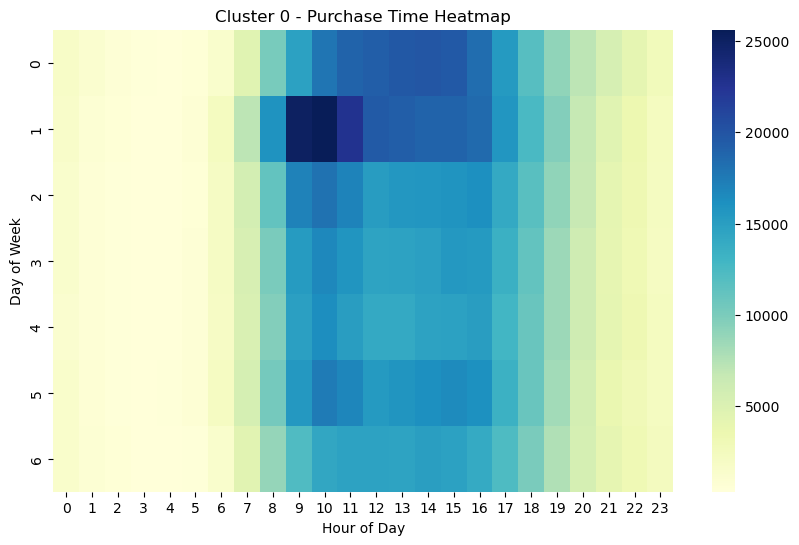

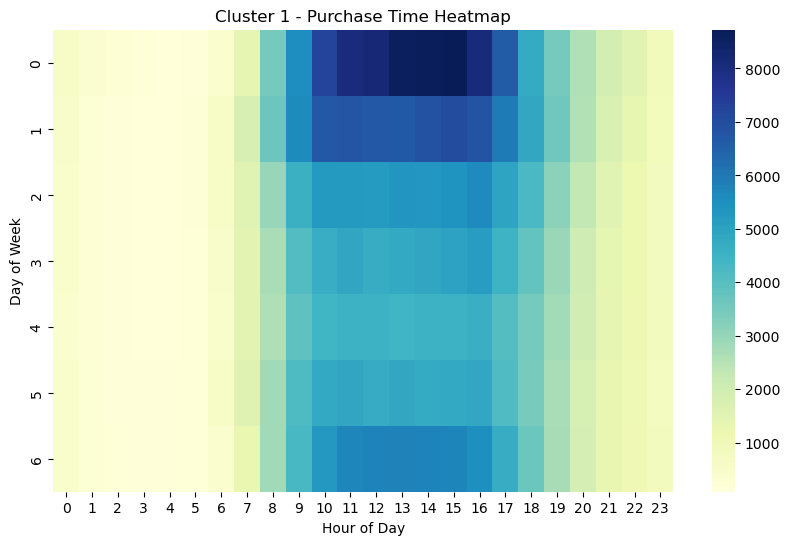

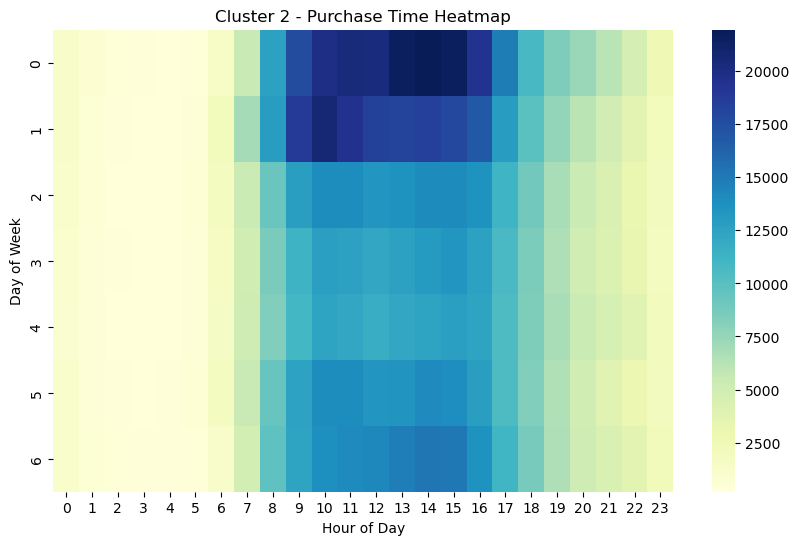

In [13]:
# Merge order data with cluster labels
orders_clustered = orders.merge(df_customers, on='user_id')

# Group by hour and day of week
time_pattern = orders_clustered.groupby(['cluster', 'order_dow', 'order_hour_of_day']).size().reset_index(name='count')

for c in sorted(time_pattern['cluster'].unique()):
    pivot = time_pattern[time_pattern['cluster'] == c].pivot(index='order_dow', columns='order_hour_of_day', values='count')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, cmap='YlGnBu')
    plt.title(f'Cluster {c} - Purchase Time Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.show()

##  Line Chart: Purchases by Hour for Each Cluster
This chart shows how purchase activity varies throughout the day for each customer cluster.

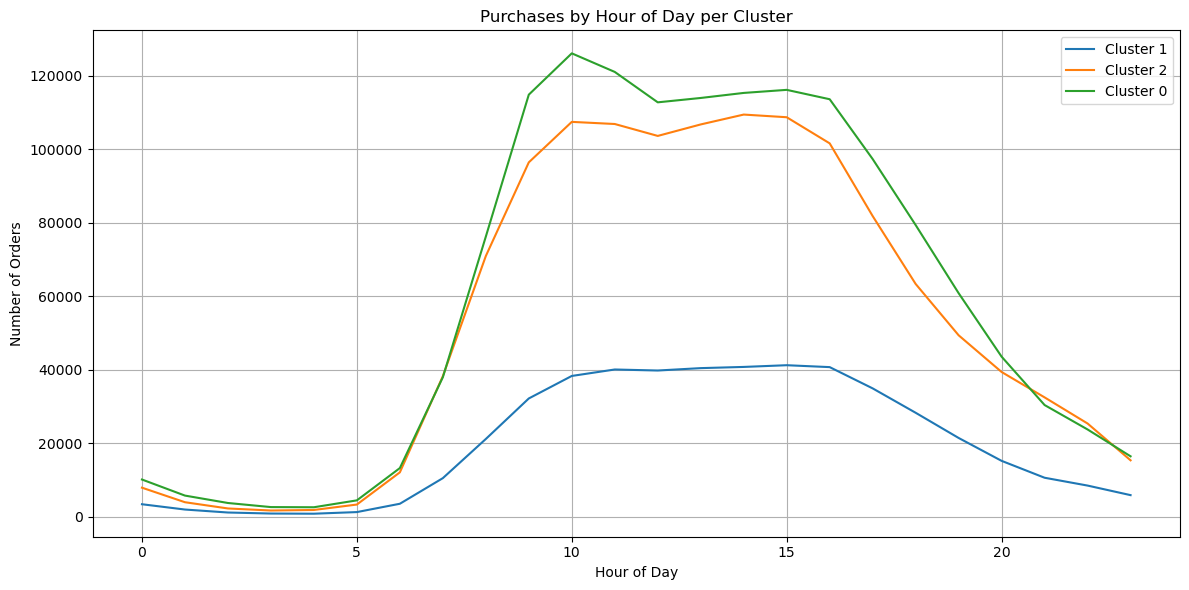

In [14]:
plt.figure(figsize=(12, 6))
for cluster in orders_clustered['cluster'].unique():
    hourly = orders_clustered[orders_clustered['cluster'] == cluster].groupby('order_hour_of_day').size()
    plt.plot(hourly.index, hourly.values, label=f'Cluster {cluster}')
plt.title('Purchases by Hour of Day per Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##  Stacked Area Chart: Purchases by Hour per Cluster
This chart shows the proportion of purchases by hour, comparing all clusters together.

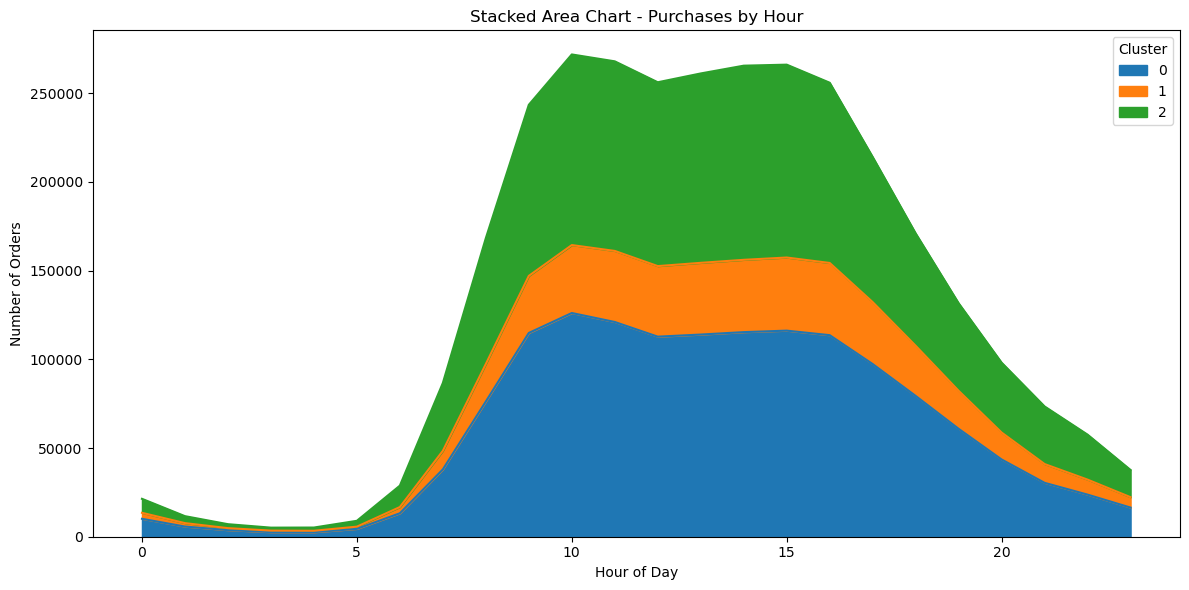

In [15]:
# Stacked area chart
hour_cluster = orders_clustered.groupby(['order_hour_of_day', 'cluster']).size().unstack().fillna(0)
hour_cluster.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Stacked Area Chart - Purchases by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

##  Faceted Bar Plots: Purchases by Hour (One Chart per Cluster)
This gives a clear view of when each cluster shops, shown separately.

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


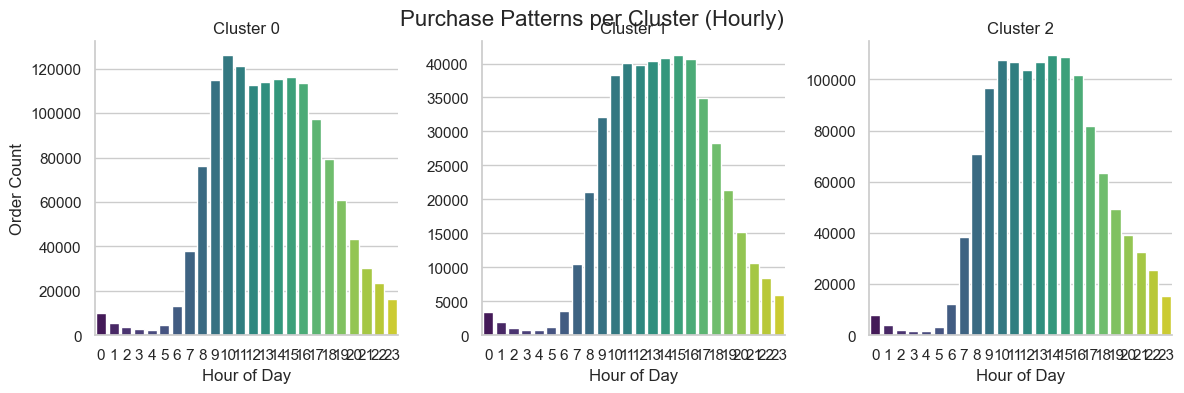

In [16]:
sns.set(style="whitegrid")

hourly_data = orders_clustered.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
g = sns.FacetGrid(hourly_data, col='cluster', col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.barplot, x='order_hour_of_day', y='count', palette='viridis')
g.set_axis_labels('Hour of Day', 'Order Count')
g.set_titles('Cluster {col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Purchase Patterns per Cluster (Hourly)', fontsize=16)
plt.show()

##  Cluster Summary & Marketing Suggestions
We summarize each cluster and suggest specific marketing strategies.

In [17]:
# Assuming 'customer_clusters' has columns: 'user_id' and 'cluster'
# and 'rfm' has user RFM data
cluster_profiles = df_customers.merge(rfm, on='user_id')
summary = cluster_profiles.groupby('cluster').mean().reset_index()
summary

,cluster,user_id,avg_order_size,avg_days_between_orders,distinct_products_bought,PCA1,PCA2,Recency,Frequency,Monetary
0,0,102987.046211,7.380123,10.759464,48.330769,-0.174618,-0.788877,11.953731,16.884479,115.281280
1,1,103472.722755,8.524492,23.240438,34.266469,-0.972121,0.723290,23.206090,6.616310,54.973293
2,2,102755.071191,16.716055,12.032779,139.593267,1.793263,0.305584,12.589569,26.958083,388.203857


###  Example Marketing Strategy per Cluster
- **Cluster 0**: High frequency, high monetary → Loyal Customers → Offer loyalty rewards.
- **Cluster 1**: High recency (long time since last order) → Dormant Customers → Send re-engagement campaigns.
- **Cluster 2**: Low frequency but high monetary → Occasional Big Spenders → Offer high-value promotions.